# DATA FOUNDATION

In [82]:
import pandas as pd
import numpy as np 
import os
import gc # Để giải phóng RAM

BASE_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/raw"

R_COEFFS = {'u': 4.239, 'g': 3.303, 'r': 2.285, 'i': 1.698, 'z': 1.263, 'y': 1.086}

In [83]:
def load_log(base_dir, mode='train'):
    log_path = os.path.join(base_dir, f"{mode}_log.csv")
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"Không tìm thấy file {mode}_log.csv")
    
    df_log=pd.read_csv(log_path)
    if mode == 'test':
        if 'target' not in df_log.columns:
            df_log['target'] = np.nan
        if 'Z_err' in df_log.columns:
            df_log['Z_err'] = 0
    return df_log

In [84]:
def clean_data(df):
    n_original = len(df)

    # 1. Xứ lý NaN
    # Nếu Flux hoặc Flux_err bị NaN -> Xóa dòng vì dữ liệu vô nghĩa
    df = df.dropna(subset=['Flux', 'Flux_err', 'Flux_corrected', 'Flux_err_corrected'])

    # Nếu EBV bị NaN, điền bằng 0 (coi như không có bụi) để tránh lỗi tính toán
    if 'EBV' in df.columns:
        df['EBV'] = df['EBV'].fillna(0)

    # 2. Xử lý Flux âm
    # Không xóa FLux âm nhưng kiểm kê nó
    n_negative = (df['Flux_corrected'] < 0).sum()

    # 3. Sắp xếp thời gian
    df = df.sort_values(by=['object_id', 'Time (MJD)'], ascending=[True, True])
    df = df.reset_index(drop=True)

    n_dropped = n_original - len(df)
    if n_dropped > 0:
        print(f"   Đã loại bỏ {n_dropped} dòng chứa NaN.")
    if n_negative > 0:
        print(f"   Lưu ý: Có {n_negative} điểm đo có Flux Âm (vẫn giữ lại).")
    
    return df

In [85]:
def process_one_split(split_name, df_log, base_dir, mode='train'):
    print(f"\n Đang xử lý: {split_name}...")
    
    lc_path = os.path.join(base_dir, split_name, f"{mode}_full_lightcurves.csv")
    
    df_meta_split = df_log[df_log['split'] == split_name].copy()
    
    df_lc = pd.read_csv(lc_path)

    df_lc_merged = df_lc.merge(
        df_meta_split[['object_id', 'EBV', 'target']],
        on='object_id',
        how='inner'
    )

    df_lc_merged['R_factor'] = df_lc_merged['Filter'].map(R_COEFFS)
    correction = 10 ** (0.4 * df_lc_merged['R_factor'] * df_lc_merged['EBV'])
    df_lc_merged['Flux_corrected'] = df_lc_merged['Flux'] * correction
    df_lc_merged['Flux_err_corrected'] = df_lc_merged['Flux_err'] * correction

    df_lc_clean = clean_data(df_lc_merged)
    del df_lc, df_lc_merged
    gc.collect()

    print(f"   -> Hoàn tất {split_name}")
    return df_lc_clean

# FEATURE ENGINEERING

STATISTICAL FEATURES

In [87]:
def generate_statistical_features(df):
    print("Đang tạo: Statistical & Percentiles Features....")

    # 1. Định nghĩa các hàm thống kê
    aggregations = {
        'Flux_corrected': [
            'mean', 'std', 'max', 'min',
            ('q05', lambda x: x.quantile(0.05)), # Phân vị 5% (thay cho Min để tránh nhiễu)
            ('q25', lambda x: x.quantile(0.25)),
            ('q75', lambda x: x.quantile(0.75)),
            ('q95', lambda x: x.quantile(0.95)), # Phân vị 95% (thay cho Max để tránh nhiễu)
            'skew', # Độ lệch phân phối (quan trọng cho TDE)
            'count' # Số lượng điểm đo
        ],
        'Flux': ['max'], # Giữ lại max flux gốc để tham chiếu
        'Flux_err': ['mean'] # Sai số trung bình (đánh giá chất lượng đo)
    }

    # 2. Groupby và Aggregation (Thực hiện song song cho tất cả object)
    # Biến đổi bảng Long-fomr thành bảng thống kê sơ bộ
    df_agg = df.groupby(['object_id', 'Filter']).agg(aggregations)

    # 3. Làm phảng MultiIndex Columns
    df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]

    # 4. Unstack (Xoay trục Filter thành cột)
    df_features = df_agg.unstack('Filter')
    df_features.columns = [f"{filter_name}_{feature}" for feature, filter_name in df_features.columns]

    # 5. Tính các đặc trưng "Global" (Tổng hợp trên mọi band)
    global_agg = df.groupby('object_id')['Flux_corrected'].agg([
        ('global_max', 'max'),
        ('global_mean', 'mean'),
        ('global_std', 'std')
    ])

    # Ghép global vào bảng features
    df_features = df_features.join(global_agg)

    # 6. Xử lý NaN sinh ra do Unstack
    # (Ví dụ: Object A không có dữ liệu filter 'u', sẽ sinh ra NaN tại các cột u_...)
    # Chiến thuật: 
    # - Với Mean, Max, Min, Quantile: Fill = 0 (coi như tối đen)
    # - Với Count: Fill = 0
    df_features = df_features.fillna(0)

    print(f"✅ Hoàn thành Nhóm 1! Kích thước: {df_features.shape}")
    return df_features

MORPHOLOGY FEATURES

In [89]:
def generate_morphology_features(df_clean, df_features_g1):
    print("   Đang tạo: Morphology Features")

    # index của dòng có Flux lớn nhất cho mỗi object/filter
    idx_max = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].idxmax()

    # index của dòng đầu tiên và dòng cuối cùng (theo thời gian)
    idx_first = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmin()
    idx_last = df_clean.groupby(['object_id', 'Filter'])['Time (MJD)'].idxmax()

     # Trích xuất dữ liệu tại các điểm mốc
    df_peaks = df_clean.loc[idx_max][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_starts = df_clean.loc[idx_first][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])
    df_ends = df_clean.loc[idx_last][['object_id', 'Filter', 'Time (MJD)', 'Flux_corrected']].set_index(['object_id', 'Filter'])

    df_peaks.columns = ['Time_peak', 'Flux_peak']
    df_starts.columns = ['Time_start', 'Flux_start']
    df_ends.columns = ['Time_end', 'Flux_end']

    # Ghép lại thành một bảng cho morphology
    df_morp = pd.concat([df_peaks, df_starts, df_ends], axis=1)

    # Tính Time, Slope
    df_morp['Rise_time'] = df_morp['Time_peak'] - df_morp['Time_start']
    df_morp['Fall_time'] = df_morp['Time_end'] - df_morp['Time_peak']
    df_morp['Rise_slope'] = (df_morp['Flux_peak'] - df_morp['Flux_start']) / (df_morp['Rise_time'] + 0.1)
    df_morp['Fall_slope'] = (df_morp['Flux_end'] - df_morp['Flux_peak']) / (df_morp['Fall_time'] + 0.1)
    
    cols_time_slope = ['Rise_time', 'Fall_time', 'Rise_slope', 'Fall_slope']
    df_morp_ts = df_morp[cols_time_slope].unstack('Filter')
    df_morp_ts.columns = [f"{filter_name}_{feat}" for feat, filter_name in df_morp_ts.columns]

    # Tính Percent Amplitude
    amp_features = []
    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    
    for f in filters:
        col_max = f"{f}_Flux_corrected_max"
        col_min = f"{f}_Flux_corrected_min"
        col_mean = f"{f}_Flux_corrected_mean"

        amp_series = (df_features_g1[col_max] - df_features_g1[col_min]) / (df_features_g1[col_mean] + 1e-6)
        amp_df = pd.DataFrame({f"{f}_percent_amplitude": amp_series})
        amp_features.append(amp_df)
    df_morp_amp = pd.concat(amp_features, axis=1)

    # Tính Kurtosis
    df_morp_kurt = df_clean.groupby(['object_id', 'Filter'])['Flux_corrected'].apply(lambda x: x.kurt()).unstack('Filter')
    df_morp_kurt.columns = [f"{f}_kurtosis" for f in df_morp_kurt.columns]

    # Tính Stetson K
    mean_cols = [c for c in df_features_g1.columns if 'mean' in c and 'Flux_corrected' in c and 'global' not in c]
    df_means = df_features_g1[mean_cols].copy()
    df_means.columns = [c.split('_')[0] for c in df_means.columns]

    df_means_flat = df_means.stack().reset_index()
    df_means_flat.columns = ['object_id', 'Filter', 'mean_flux']
    df_stetson = pd.merge(df_clean, df_means_flat, on=['object_id', 'Filter'], how='left')

    df_stetson['delta'] = (df_stetson['Flux_corrected'] - df_stetson['mean_flux']) / (df_stetson['Flux_err_corrected'] + 1e-6)
    
    df_stetson['abs_delta'] = df_stetson['delta'].abs()
    df_stetson['delta_sq'] = df_stetson['delta'] ** 2

    g = df_stetson.groupby(['object_id', 'Filter'])
    mean_abs_delta = g['abs_delta'].mean()
    mean_delta_sq = g['delta_sq'].mean()
    stetson_k = mean_abs_delta / (np.sqrt(mean_delta_sq) + 1e-6)

    df_morp_stetson = stetson_k.unstack('Filter')
    df_morp_stetson.columns = [f"{f}_stetson_k" for f in df_morp_stetson.columns]


    # Tạo bảng morphology features
    df_morp_final = df_morp_ts.join([df_morp_amp, df_morp_kurt, df_morp_stetson])

    # Xử lý NaN nếu có
    df_morp_final = df_morp_final.fillna(0)

    print(f"Hoàn thành Nhóm 2! Kích thước: {df_morp_final.shape}")
    return df_morp_final

COLOR FEATURES

In [91]:
def generate_color_features(df_features_g1):
    print("   Đang tạo: Color Features")

    filters = ['u', 'g', 'r', 'i', 'z', 'y']
    new_features = []

    for i in range(len(filters) - 1):
        f1 = filters[i]
        f2 = filters[i+1]

        col_f1_mean = f"{f1}_Flux_corrected_mean"
        col_f2_mean = f"{f2}_Flux_corrected_mean"

        ratio_mean = df_features_g1[col_f1_mean] / (df_features_g1[col_f2_mean] + 1e-6)
        diff_mean = df_features_g1[col_f1_mean] - df_features_g1[col_f2_mean]

        col_f1_max = f"{f1}_Flux_corrected_max"
        col_f2_max = f"{f2}_Flux_corrected_max"

        ratio_max = df_features_g1[col_f1_max] / (df_features_g1[col_f2_max] + 1e-6)
        diff_max = df_features_g1[col_f1_max] - df_features_g1[col_f2_max]

        temp_df = pd.DataFrame({
            f'{f1}_{f2}_mean_ratio': ratio_mean,
            f'{f1}_{f2}_mean_diff': diff_mean,
            f'{f1}_{f2}_max_ratio': ratio_max,
            f'{f1}_{f2}_max_diff': diff_max
        }, index=df_features_g1.index)

        new_features.append(temp_df)

    f_start, f_end = 'u', 'y'
    col_start = f"{f_start}_Flux_corrected_mean"
    col_end = f"{f_end}_Flux_corrected_mean"

    blue_red_ratio = df_features_g1[col_start] / (df_features_g1[col_end] + 1e-6)
    temp_extreme = pd.DataFrame({f'{f_start}_{f_end}_mean_ratio': blue_red_ratio}, index=df_features_g1.index)
    new_features.append(temp_extreme)

    df_colors = pd.concat(new_features, axis=1)
    df_colors = df_colors.replace([np.inf, -np.inf], 0).fillna(0)

    print(f"Hoàn thành Nhóm 3! Kích thước: {df_colors.shape}")
    return df_colors


BAZIN

In [95]:
from scipy.optimize import least_squares
import warnings

# Tắt cảnh báo tính toán (overflow) để log đỡ rác
warnings.filterwarnings("ignore")

def bazin_func(params, t):
    """
    params: [A, B, t0, tau_rise, tau_fall]
    t: mảng thời gian
    """
    A, B, t0, tau_rise, tau_fall = params

    arg_fall = -(t - t0) / (tau_fall + 1e-5)
    arg_rise = -(t - t0) / (tau_rise + 1e-5)

    return A * (np.exp(arg_fall) / (1 + np.exp(arg_rise))) + B

In [96]:
def residuals(params, t, flux, flux_err):
    """
    Hàm tính sai số để tối ưu hóa.
    Mục tiêu: Minimizing (Dữ liệu thực - Dữ liệu bazin) / Sai số đo
    """
    model = bazin_func(params, t)
    weights = 1.0 / (flux_err + 1e-5)
    return (flux - model) * weights

In [97]:
def fit_bazin_one_series(time, flux, flux_err):
    """
    Hàm thực hiện fit cho 1 chuỗi thời gian (1 filter của 1 object)
    Trả về: [A, B, t0, tau_rise, tau_fall] và fit_error
    """

    # Chuyển về numpy array và sort theo thời gian
    idx = np.argsort(time)
    t = time[idx]
    f = flux[idx]
    e = flux_err[idx]

    # Chuẩn hóa thời gian để tính toán ổn định hơn (t bắt đầu từ 0)
    t_min = t.min()
    t_norm = t - t_min

    # Dự đoán tham số khởi tạo (Nếu đoán sai, least_squares sẽ không hội tụ)
    max_flux_idx = np.argmax(f)
    max_flux = f[max_flux_idx]

    guess_A = max_flux # Biên độ ~ Flux cao nhất
    guess_B = np.median(f[:3]) if len(f) > 3 else 0 # Nền ~ giá trị đoạn đầu
    guess_t0 = t_norm[max_flux_idx] # Đỉnh ~ thời điểm flux cao nhất
    guess_rise = 10.0 # Giả định ban đầu: tăng trong 10 giây
    guess_fall = 30.0 # Giả định band dầu: giảm trong 30 giây

    x0 = [guess_A, guess_B, guess_t0, guess_rise, guess_fall]

    # Giới hạn tham số
    # A > 0, Tau > 0. t0 nằm trong khoảng thời gian quan sát
    lower_bounds = [0, -np.inf, t_norm.min()-50, 0.1, 0.1]
    upper_bounds = [np.inf, np.inf, t_norm.max()+50, 200, 500]

    try:
        # Chạy tối ưu hóa
        res = least_squares(
            residuals,
            x0,
            args=(t_norm, f, e),
            bounds=(lower_bounds, upper_bounds),
            method='trf', # Trust Region Reflective
            loss='soft_l1' # Giảm ảnh hưởng của Outliers
        )

        final_params = res.x
        final_params[2] += t_min

        # Tính chi square (độ tốt của fit)
        chisq = np.sum(res.fun**2) / (len(f)-5)

        return list(final_params) + [chisq]
    except Exception:
        # Nếu lỗi, trả về NaN
        return [np.nan] * 6

In [98]:
def generate_bazin_features(df_clean):
    print("Đang chạy Bazin Parametric Fitting....")

    features = []
    object_ids = df_clean['object_id'].unique()
    filters = ['u', 'g', 'r', 'i', 'z', 'y']

    # Lặp qua từng object. Để tối ưu, sau này có thể dùng jobLib Parallel
    cnt = 0
    total = len(object_ids)

    for obj_id in object_ids:
        df_obj = df_clean[df_clean['object_id'] == obj_id]

        obj_feats = {'object_id' : obj_id}

        for flt in filters:
            df_flt = df_obj[df_obj['Filter'] == flt]

            if len(df_flt) < 5:
                # Không đủ điểm để fit (cần tối thiểu 5 điểm cho 5 tham số)
                params = [np.nan] * 6
            else:
                params = fit_bazin_one_series(
                    df_flt['Time (MJD)'].values,
                    df_flt['Flux_corrected'].values,
                    df_flt['Flux_err_corrected'].values
                )
            
            # Lưu két quả: u_banzin_A, u_bazin_tau_rise, ...
            prefix = f"{flt}_bazin"
            obj_feats[f"{prefix}_A"] = params[0]
            obj_feats[f"{prefix}_B"] = params[1]
            obj_feats[f"{prefix}_t0"] = params[2]
            obj_feats[f"{prefix}_tau_rise"] = params[3]
            obj_feats[f"{prefix}_tau_fall"] = params[4]
            obj_feats[f"{prefix}_chisq"] = params[5]
        
        features.append(obj_feats)

        cnt += 1
        if cnt % 50 == 0:
            print(f"   -> Đã fit xong {cnt}/{total} vật thể.")
        
    df_bazin = pd.DataFrame(features)
    df_bazin.set_index('object_id', inplace=True)

    df_bazin = df_bazin.fillna(-1)

    print(f"Hoàn tất Bazin Fitting! Kích thước: {df_bazin.shape}")

    return df_bazin

# PROCESS TRAIN DATA

In [101]:
from tqdm import tqdm

PROCESSED_DIR = "/MALLORN-Astronomical-Classification-Challenge/data/processed"
PROCESSED_TRAIN_FILE = "processed_train_full_lc.csv"

df_train_log = load_log(BASE_DIR, mode='train')
processed_chunks = []

print("--- Bắt đầu xử lý 20 splits---")

for i in range(1, 21):
    split_name = f"split_{i:02d}"
    print(f"Đang xử lý: {split_name} ({i}/20)...")

    df_clean = process_one_split(split_name, df_train_log, BASE_DIR, mode='train')
    if df_clean is None:
        continue

    df_g1 = generate_statistical_features(df_clean)
    df_g2 = generate_morphology_features(df_clean, df_g1)
    df_g3 = generate_color_features(df_g1)
    df_g4 = generate_bazin_features(df_clean)

    current_ids = df_g1.index
    df_train_log_tmp = df_train_log[df_train_log['object_id'].isin(current_ids)].copy()

    df_temp = pd.concat([df_g1, df_g2, df_g3], axis=1)
    df_temp = df_temp.join(df_g4, how='left')
    df_chunk_final = df_train_log_tmp.set_index('object_id').join(df_temp, how='inner')
    
    processed_chunks.append(df_chunk_final)

    print(f"   -> Xử lý xong {split_name}. Kích thước chunk: {df_chunk_final.shape}")

    # Dọn dẹp RAM
    del df_clean, df_g1, df_g2, df_g3, df_g4, df_chunk_final, df_train_log_tmp
    gc.collect()

print("Đang ghép nối tất cả các splits...")
if (len(processed_chunks) > 0):
    df_final_train_lc = pd.concat(processed_chunks, axis=0)
    print(f"Tổng kích thước: {df_final_train_lc.shape}")
    print(f"Tổng số TDE tìm thấy: {df_final_train_lc['target'].sum()}")

    # Lưu lại file trong processed
    save_path = os.path.join(PROCESSED_DIR, PROCESSED_TRAIN_FILE)
    df_final_train_lc.to_csv(save_path, index=True)
    print(f"Đã lưu file tại: {save_path}")


--- Bắt đầu xử lý 20 splits---
Đang xử lý: split_01 (1/20)...

 Đang xử lý: split_01...
   Đã loại bỏ 11 dòng chứa NaN.
   Lưu ý: Có 10254 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (155, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (155, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (155, 21)
Đang chạy Bazin Parametric Fitting....
   -> Đã fit xong 50/155 vật thể.
   -> Đã fit xong 100/155 vật thể.
   -> Đã fit xong 150/155 vật thể.
Hoàn tất Bazin Fitting! Kích thước: (155, 36)
   -> Xử lý xong split_01. Kích thước chunk: (155, 181)
Đang xử lý: split_02 (2/20)...

 Đang xử lý: split_02...
   Đã loại bỏ 6 dòng chứa NaN.
   Lưu ý: Có 8713 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_02
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (170, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (17

# OPTUNA

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import optuna
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # Giảm bớt cho log đỡ rối

In [3]:
df_final_train_lc = pd.read_csv("/MALLORN-Astronomical-Classification-Challenge/data/processed/processed_train_full_lc.csv")

In [4]:
print("  CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ...")

df_train = df_final_train_lc.copy()

drop_cols = ['object_id', ' SpecType', 'English Translation', 'split', 'target', 'prediction']
existing_drop = [c for c in drop_cols if c in df_train.columns]

X = df_train.drop(columns=existing_drop)
X = X.select_dtypes(exclude=['object'])
X = X.replace([np.inf, -np.inf], np.nan).fillna(-999)

# LightGBM
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

y = df_train['target']

print(f" DỮ LIỆU ĐÃ SẴN SÀNG: {X.shape}")

# Optuna
scale_pos_weight_init = (len(y) -y.sum()) / y.sum()

  CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ...
 DỮ LIỆU ĐÃ SẴN SÀNG: (3043, 177)


In [104]:
def objective_xgb(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, scale_pos_weight_init), 
        'eval_metric': 'logloss',
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
        y_prob = model.predict_proba(X_val)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [105]:
def objective_lgbm(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                  callbacks=[lgb.early_stopping(50, verbose=False)])
        
        y_prob = model.predict_proba(X_val)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [106]:
def objective_cat(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, scale_pos_weight_init),
        'loss_function': 'Logloss',
        'verbose': False,
        'random_seed': 42,
        'early_stopping_rounds': 50,
        'allow_writing_files': False
    }
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Dùng Pool cho CatBoost
        train_pool = Pool(X_tr, y_tr)
        val_pool = Pool(X_val, y_val)
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, verbose=False)
        
        y_prob = model.predict_proba(val_pool)[:, 1]
        best_f1 = 0
        for th in np.arange(0.2, 0.8, 0.05):
            score = f1_score(y_val, (y_prob >= th).astype(int))
            if score > best_f1: best_f1 = score
        f1_scores.append(best_f1)
        
    return np.mean(f1_scores)

In [113]:
print("   TỐI ƯU THAM SỐ BẰNG OPTUNA")

N_TRIALS = 100

# XGBoost
print(f"---Tuning XGBoost ({N_TRIALS} trials) ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'n_estimators': 1500, 'eval_metric': 'logloss', 'objective': 'binary:logistic',
                        'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1, 'early_stopping_rounds': 100})
print(f"Best XGB F1: {study_xgb.best_value:.4f}")

# LightGBM
print(f"--- Tuning LightGBM ({N_TRIALS} trials) ---")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'n_estimators': 1500, 'random_state': 42, 'n_jobs': -1, 'verbose': -1})
print(f"Best LightGBM F1: {study_lgbm.best_value:.4f}")

# CatBoost
print(f"--- Tuning CatBoost ({N_TRIALS} trials) ---")
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_cat, n_trials=N_TRIALS)
best_cat_params = study_cat.best_params
best_cat_params.update({'iterations': 1500, 'loss_function': 'Logloss', 'verbose': False, 
                        'random_seed': 42, 'allow_writing_files': False, 'early_stopping_rounds': 100})
print(F"Best CatBoost F1: {study_cat.best_value:.4f}")

   TỐI ƯU THAM SỐ BẰNG OPTUNA
---Tuning XGBoost (100 trials) ---
Best XGB F1: 0.5828
--- Tuning LightGBM (100 trials) ---
Best LightGBM F1: 0.5638
--- Tuning CatBoost (100 trials) ---
Best CatBoost F1: 0.5490


# ENSEMBLE

In [5]:
xgb_params = {
    'learning_rate': 0.051518799097782834,
    'max_depth': 10,
    'subsample': 0.9106527930168713,
    'colsample_bytree': 0.7028192063273316,
    'gamma': 0.6560553174292321,
    'reg_alpha': 8.328749198565307,
    'reg_lambda': 1.2457482664378638,
    'scale_pos_weight': 10.692975531517197,
    'n_estimators': 1500,
    'eval_metric': 'logloss',
    'objective': 'binary:logistic',
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 100
}

lgbm_params = {
    'learning_rate': 0.09910411868030085,
    'num_leaves': 51,
    'max_depth': 10,
    'subsample': 0.8473086396918044,
    'colsample_bytree': 0.6978315039075688,
    'reg_alpha': 7.089502551216929,
    'reg_lambda': 3.3773533645913636,
    'class_weight': 'balanced',
    'n_estimators': 1500,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
}

cat_params = {
    'learning_rate': 0.01844791176169218,
    'depth': 4,
    'l2_leaf_reg': 2.082185084558599,
    'random_strength': 5.209528399826417,
    'bagging_temperature': 0.5151147661811961,
    'scale_pos_weight': 7.369664685132736,
    'iterations': 1500,
    'loss_function': 'Logloss',
    'verbose': False,
    'random_seed': 42,
    'allow_writing_files': False,
    'early_stopping_rounds': 100
}

In [19]:
X_selected = X.drop(columns=['global_max', 'i_kurtosis', 'z_kurtosis', 
                     'y_Flux_corrected_min', 'r_Flux_corrected_mean', 
                     'z_y_mean_ratio', 'z_Flux_corrected_q75', 'y_bazin_A', 
                     'z_stetson_k', 'y_Flux_corrected_q75', 'g_Rise_slope', 
                     'y_Rise_slope', 'u_Rise_slope', 'i_Flux_corrected_mean', 
                     'i_Flux_corrected_std', 'g_Flux_corrected_count', 
                     'i_Flux_corrected_count', 'y_Rise_time', 
                     'g_Flux_corrected_mean', 'Z_err'])

In [20]:
print("\n TRAINING & ENSEMBLE ....")

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(X_selected))
oof_lgbm = np.zeros(len(X_selected))
oof_cat = np.zeros(len(X_selected))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"   -> Đang chạy Fold {fold+1}/{N_FOLDS}...")
    X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model_xgb = xgb.XGBClassifier(**xgb_params)
    model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = model_xgb.predict_proba(X_val)[:, 1]

    model_lgbm = lgb.LGBMClassifier(**lgbm_params)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(100, verbose=False)])
    oof_lgbm[val_idx] = model_lgbm.predict_proba(X_val)[:, 1]

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    model_cat = CatBoostClassifier(**cat_params)
    model_cat.fit(train_pool, eval_set=val_pool, verbose=False)
    oof_cat[val_idx] = model_cat.predict_proba(val_pool)[:, 1]


 TRAINING & ENSEMBLE ....
   -> Đang chạy Fold 1/5...
   -> Đang chạy Fold 2/5...
   -> Đang chạy Fold 3/5...
   -> Đang chạy Fold 4/5...
   -> Đang chạy Fold 5/5...


HAND ENSEMLE

In [21]:
print("\n KẾT QUẢ SAU KHI TUNING")

def get_best_f1(y_true, y_prob):
    best_score = 0
    best_th = 0
    for th in np.arange(0.1, 0.9, 0.01):
        s = f1_score(y_true, (y_prob >= th).astype(int))
        if s > best_score: 
            best_score = s
            best_th = th
    return best_score, best_th

f1_xgb, th_xgb = get_best_f1(y, oof_xgb)
print(f"   XGBoost   : F1 = {f1_xgb:.4f} (Thresh={th_xgb:.2f})")

f1_lgbm, th_lgbm = get_best_f1(y, oof_lgbm)
print(f"   LightGBM  : F1 = {f1_lgbm:.4f} (Thresh={th_lgbm:.2f})")

f1_cat, th_cat = get_best_f1(y, oof_cat)
print(f"   CatBoost  : F1 = {f1_cat:.4f} (Thresh={th_cat:.2f})")

print("\n  TỐI ƯU HÓA TRỌNG SỐ ENSEMBLE...")
# Thử nghiệm các tổ hợp trọng số
best_ensemble_f1 = 0
best_weights = (0, 0, 0)
best_ensemble_th = 0

# Grid search trọng số (w1, w2, w3)
weights_to_try = [
    (1, 1, 1), # Trung bình cộng
    (2, 1, 1), (1, 2, 1), (1, 1, 2), # Ưu tiên 1 model
    (2, 2, 1), (2, 1, 2), (1, 2, 2),
    (3, 1, 1), (1, 3, 1), (1, 1, 3)
]

for w1, w2, w3 in weights_to_try:
    total = w1 + w2 + w3
    blend_pred = (w1*oof_xgb + w2*oof_lgbm + w3*oof_cat) / total
    
    score, th = get_best_f1(y, blend_pred)
    if score > best_ensemble_f1:
        best_ensemble_f1 = score
        best_weights = (w1, w2, w3)
        best_ensemble_th = th

print(f"  KẾT QUẢ ENSEMBLE TỐT NHẤT:")
print(f"   Trọng số: XGB={best_weights[0]}, LGBM={best_weights[1]}, CAT={best_weights[2]}")
print(f"   F1-Score: {best_ensemble_f1:.4f}")
print(f"   Threshold: {best_ensemble_th:.2f}")


 KẾT QUẢ SAU KHI TUNING
   XGBoost   : F1 = 0.5676 (Thresh=0.42)
   LightGBM  : F1 = 0.5430 (Thresh=0.50)
   CatBoost  : F1 = 0.5455 (Thresh=0.47)

  TỐI ƯU HÓA TRỌNG SỐ ENSEMBLE...
  KẾT QUẢ ENSEMBLE TỐT NHẤT:
   Trọng số: XGB=2, LGBM=2, CAT=1
   F1-Score: 0.5732
   Threshold: 0.42


In [14]:
def plot_feature_importance(models, feature_names):
    feature_importance = pd.DataFrame({'feature' : feature_names})

    if 'XGBoost' in models:
        imp = models['XGBoost'].feature_importances_
        feature_importance['xgb_imp'] = imp
        feature_importance['xgb_imp'] /= feature_importance['xgb_imp'].max()

    if 'LightGBM' in models:
        imp = models['LightGBM'].feature_importances_
        feature_importance['lgb_imp'] = imp
        feature_importance['lgb_imp'] /= feature_importance['lgb_imp'].max()

    if 'CatBoost' in models:
        imp = models['CatBoost'].get_feature_importance()
        feature_importance['cat_imp'] = imp
        feature_importance['cat_imp'] /= feature_importance['cat_imp'].max()

    # Tính trung bình cộng
    feature_importance['avg_imp'] = feature_importance[['xgb_imp', 'lgb_imp', 'cat_imp']].mean(axis=1)
    
    feature_importance = feature_importance.sort_values('avg_imp', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(12, 10))
    sns.barplot(x='avg_imp', y='feature', data=feature_importance.head(30), palette='viridis')
    plt.title('TOP 30 FEATURE IMPORTANCE (AVERAGE OF 3 MODELS)', fontsize=15)
    plt.xlabel('Normalized Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

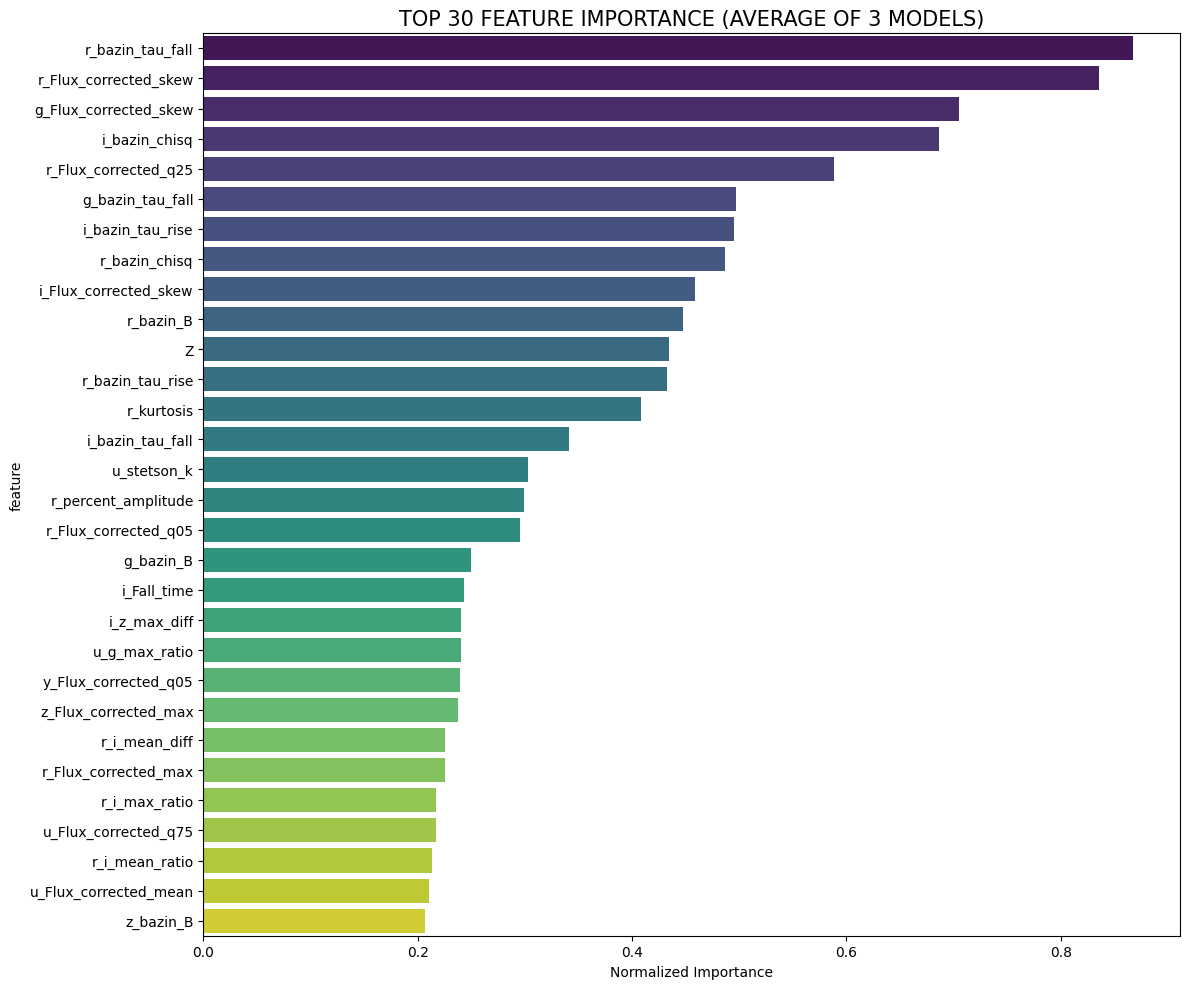


 CÁC FEATURES YẾU NHẤT (CÓ THỂ LOẠI BỎ):
['global_max', 'i_kurtosis', 'z_kurtosis', 'y_Flux_corrected_min', 'r_Flux_corrected_mean', 'z_y_mean_ratio', 'z_Flux_corrected_q75', 'y_bazin_A', 'z_stetson_k', 'y_Flux_corrected_q75', 'g_Rise_slope', 'y_Rise_slope', 'u_Rise_slope', 'i_Flux_corrected_mean', 'i_Flux_corrected_std', 'g_Flux_corrected_count', 'i_Flux_corrected_count', 'y_Rise_time', 'g_Flux_corrected_mean', 'Z_err']


In [17]:
models_dict = {
    'XGBoost': model_xgb,
    'LightGBM': model_lgbm,
    'CatBoost': model_cat
}

feature_names = X.columns.tolist()

df_imp = plot_feature_importance(models_dict, feature_names)

print("\n CÁC FEATURES YẾU NHẤT (CÓ THỂ LOẠI BỎ):")
print(df_imp.tail(20)['feature'].tolist())

# PROCESS TEST DATA

In [20]:
PROCESSED_TEST_FILE = "processed_test_full_lc.csv"

df_test_log = load_log(BASE_DIR, mode='test')
processed_chunks = []

print("--- Bắt đầu xử lý 20 splits---")

for i in range(1, 21):
    split_name = f"split_{i:02d}"
    print(f"Đang xử lý: {split_name} ({i}/20)...")

    df_clean = process_one_split(split_name, df_test_log, BASE_DIR, mode='test')
    if df_clean is None:
        continue

    df_g1 = generate_statistical_features(df_clean)
    df_g2 = generate_morphology_features(df_clean, df_g1)
    df_g3 = generate_color_features(df_g1)
    df_g4 = generate_bazin_features(df_clean)

    current_ids = df_g1.index
    df_test_log_tmp = df_test_log[df_test_log['object_id'].isin(current_ids)].copy()

    df_temp = pd.concat([df_g1, df_g2, df_g3], axis=1)
    df_temp = df_temp.join(df_g4, how='left')
    df_chunk_final = df_test_log_tmp.set_index('object_id').join(df_temp, how='inner')
    
    processed_chunks.append(df_chunk_final)

    print(f"   -> Xử lý xong {split_name}. Kích thước chunk: {df_chunk_final.shape}")

    # Dọn dẹp RAM
    del df_clean, df_g1, df_g2, df_g3, df_g4, df_chunk_final, df_test_log_tmp
    gc.collect()

print("Đang ghép nối tất cả các splits...")
if (len(processed_chunks) > 0):
    df_final_test_lc = pd.concat(processed_chunks, axis=0)

    # Lưu lại file trong processed
    save_path = os.path.join(PROCESSED_DIR, PROCESSED_TEST_FILE)
    df_final_test_lc.to_csv(save_path, index=True)
    print(f"Đã lưu file tại: {save_path}")


--- Bắt đầu xử lý 20 splits---
Đang xử lý: split_01 (1/20)...

 Đang xử lý: split_01...
   Đã loại bỏ 23 dòng chứa NaN.
   Lưu ý: Có 22358 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_01
Đang tạo: Statistical & Percentiles Features....
✅ Hoàn thành Nhóm 1! Kích thước: (364, 75)
   Đang tạo: Morphology Features
Hoàn thành Nhóm 2! Kích thước: (364, 42)
   Đang tạo: Color Features
Hoàn thành Nhóm 3! Kích thước: (364, 21)
Đang chạy Bazin Parametric Fitting....
   -> Đã fit xong 50/364 vật thể.
   -> Đã fit xong 100/364 vật thể.
   -> Đã fit xong 150/364 vật thể.
   -> Đã fit xong 200/364 vật thể.
   -> Đã fit xong 250/364 vật thể.
   -> Đã fit xong 300/364 vật thể.
   -> Đã fit xong 350/364 vật thể.
Hoàn tất Bazin Fitting! Kích thước: (364, 36)
   -> Xử lý xong split_01. Kích thước chunk: (364, 181)
Đang xử lý: split_02 (2/20)...

 Đang xử lý: split_02...
   Đã loại bỏ 8 dòng chứa NaN.
   Lưu ý: Có 25983 điểm đo có Flux Âm (vẫn giữ lại).
   -> Hoàn tất split_02
Đang tạo: Statisti

KeyboardInterrupt: 

# CREATE SUBMISSION

In [22]:
df_final_test = pd.read_csv("/MALLORN-Astronomical-Classification-Challenge/data/processed/processed_test_full_lc.csv")
train_cols = X_selected.columns.tolist()
X_test = df_final_test[train_cols]
X_test_cat = X_test.copy()

y_pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
y_pred_lgbm = model_lgbm.predict_proba(X_test)[:, 1] 
y_pred_cat = model_cat.predict_proba(X_test_cat)[:, 1]

y_pred_blend = (2 * y_pred_xgb + 2 * y_pred_lgbm + y_pred_cat) / 5

THRESHOLD = 0.42
submission = pd.DataFrame({
    'object_id': df_final_test['object_id'],
    'prediction': (y_pred_blend > THRESHOLD).astype(int)
})

sub_filename = "submission_05.csv"
submission.to_csv(sub_filename, index=False)